In [1]:
import openmc
import openmc.lib
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
import numpy as np

# OpenMC simulation parameters
batches = 20
inactive = 10
particles = 100000

In [2]:
# Instantiate some Materials and register the appropriate Nuclides
#UO2 composition
uo2 = openmc.Material(material_id=1, name='UO2 fuel at 4.5% wt enrichment')
uo2.set_density('g/cm3', 10.55)
uo2.add_element('U', 1, enrichment=4.5)
uo2.add_element('O', 2)
uo2.temperature = 900

#Helium Composition
helium = openmc.Material(material_id=2, name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 1,'wo')
helium.temperature = 604
#zircaloy clad
zircaloy = openmc.Material(material_id=3, name='E110')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Nb', 0.01  , 'wo')
zircaloy.add_element('Fe', 0.00009, 'wo')
zircaloy.add_element('O', 0.00060  , 'wo')
zircaloy.add_element('Zr', 0.98931, 'wo')
zircaloy.temperature = 604
# water 
water = openmc.Material(material_id=4, name='Water Moderator')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 0.1111,'wo' )
water.add_nuclide('O16', 0.8889 ,'wo')
water.add_s_alpha_beta('c_H_in_H2O')
water.temperature = 577
# Instantiate a Materials collection and export to XML
materials_file = openmc.Materials([uo2, helium, zircaloy, water])
materials_file.cross_sections = 'cross_sections.xml'
materials_file.export_to_xml()

HexLattice
	ID             =	4
	Name           =	
	Orientation    =	y
	# Rings        =	8
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.7851,)
	Outer          =	3
	Universes      
       1
      1 1
     1 2 1
    1 1 1 1
   1 1 1 1 1
  1 1 1 1 1 1
 1 1 1 2 1 1 1
1 1 1 1 1 1 1 1
 2 1 1 1 1 1 2
1 1 1 1 1 1 1 1
 1 2 1 1 1 2 1
1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1
1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1
 1 2 1 1 1 2 1
1 1 1 1 1 1 1 1
 2 1 1 1 1 1 2
1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1
  1 1 1 1 1 1
   1 1 1 1 1
    1 1 1 1
     1 2 1
      1 1
       1


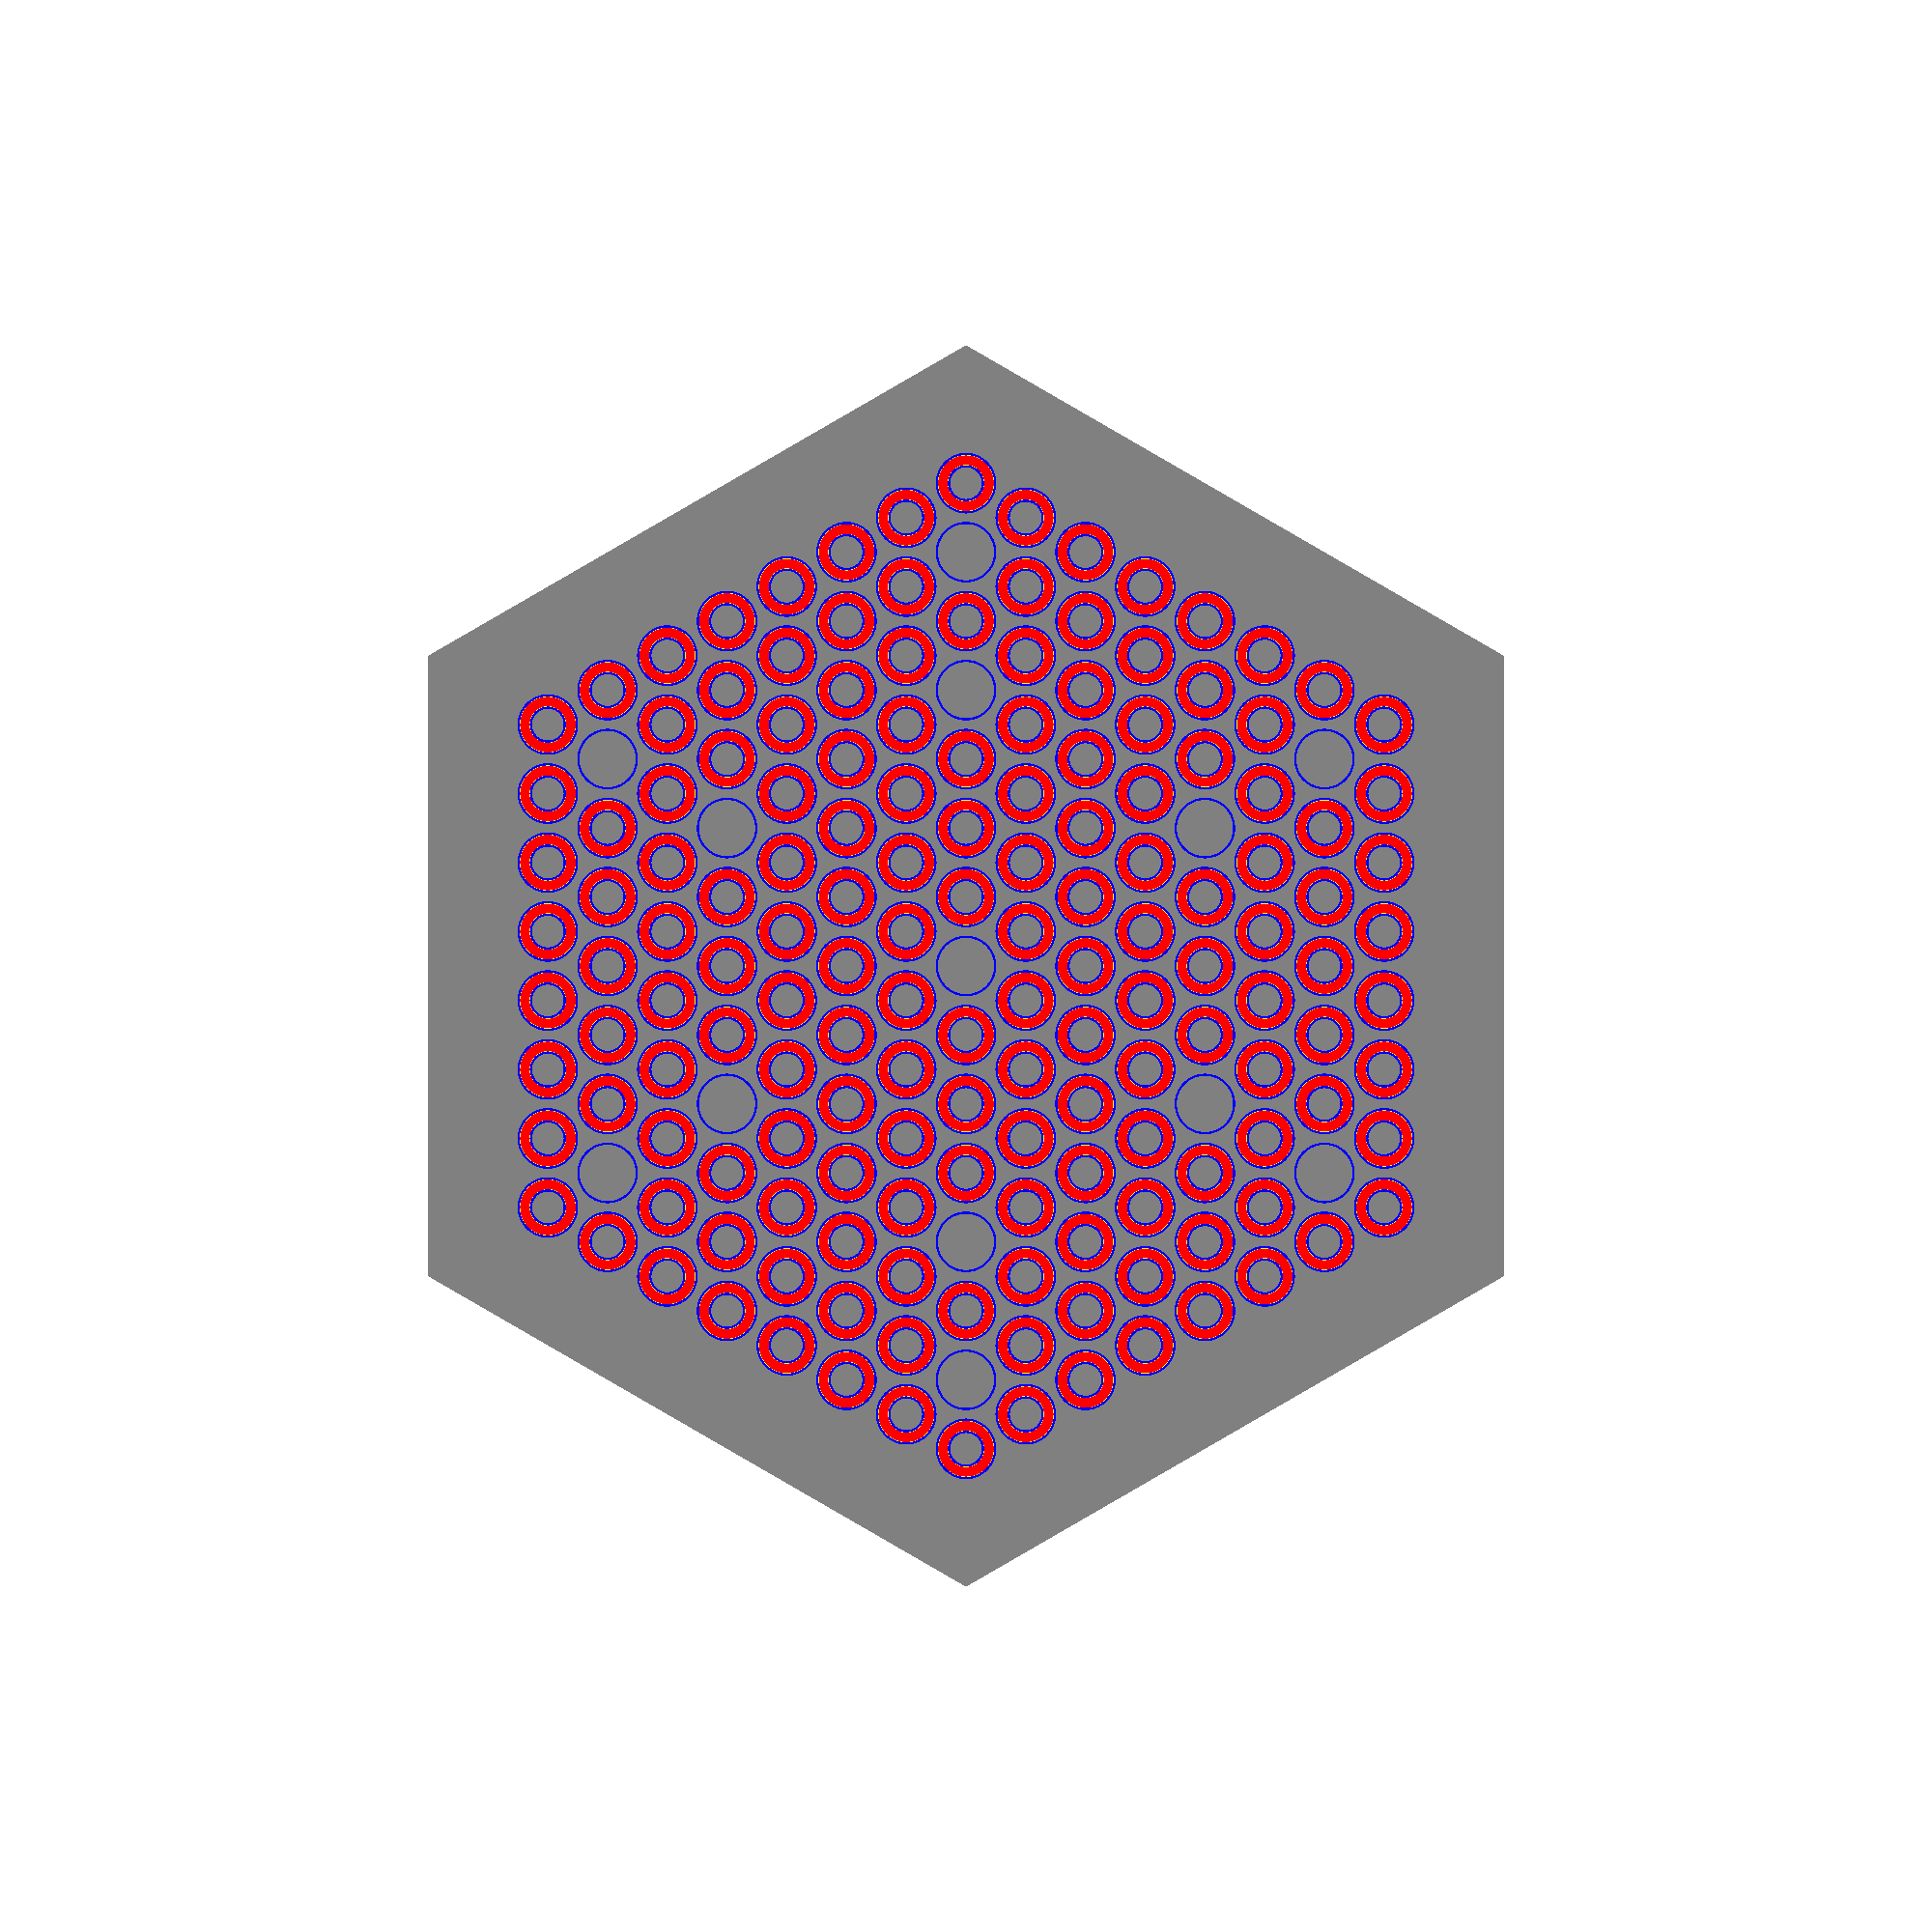

In [3]:
# Instantiate ZCylinder surfaces

inner_clad_ir  = openmc.ZCylinder(surface_id=1, x0=0, y0=0, r=0.4091, name='Clad IIR')
inner_clad_or  = openmc.ZCylinder(surface_id=2, x0=0, y0=0, r=0.4662, name='Clad IOR')
fuel_ir        = openmc.ZCylinder(surface_id=3, x0=0, y0=0, r=0.4741, name='Fuel IR')
fuel_or        = openmc.ZCylinder(surface_id=4, x0=0, y0=0, r=0.717, name='Fuel OR')
outer_clad_ir  = openmc.ZCylinder(surface_id=5, x0=0, y0=0, r=0.7269, name='Clad OIR')
outer_clad_or  = openmc.ZCylinder(surface_id=6, x0=0, y0=0, r=0.784, name='Clad OOR')
left           = openmc.XPlane(surface_id=7, x0=-1.1, name='left')
right          = openmc.XPlane(surface_id=8, x0=1.1, name='right')
bottom         = openmc.YPlane(surface_id=9, y0=-1.1, name='bottom')
top            = openmc.YPlane(surface_id=10, y0=1.1, name='top')

left.boundary_type = 'reflective'
right.boundary_type = 'reflective'
top.boundary_type = 'reflective'
bottom.boundary_type = 'reflective'

# Instantiate Cells
hole = openmc.Cell(cell_id=1,name='Hole')
clad1 = openmc.Cell(cell_id=2, name='Cladding1')
gap1 = openmc.Cell(cell_id=3, name='Gap1')
fuel1 = openmc.Cell(cell_id=4, name='Fuel1')
gap2 = openmc.Cell(cell_id=5, name='Gap2')
clad2 = openmc.Cell(cell_id=6, name='Cladding2')
water1 = openmc.Cell(cell_id=7, name='Water')

# Use surface half-spaces to define regions
hole.region = -inner_clad_ir 
clad1.region = +inner_clad_ir & -inner_clad_or
gap1.region  = +inner_clad_or & -fuel_ir
fuel1.region  = +fuel_ir & -fuel_or
gap2.region  = +fuel_or & -outer_clad_ir 
clad2.region = +outer_clad_ir  & -outer_clad_or
water1.region = +outer_clad_or & +left & -right & +bottom & -top
# Register Materials with Cells
hole.fill = water
clad1.fill = zircaloy
gap1.fill = helium
fuel1.fill = uo2
gap2.fill = helium
clad2.fill = zircaloy
water1.fill = water
# Instantiate Universe
f = openmc.Universe(universe_id=1,cells=[hole, clad1, gap1, fuel1, gap2, clad2, water1])

outer_clad_ir  = openmc.ZCylinder(surface_id=11, x0=0, y0=0, r=0.7269, name='Clad OIR')
outer_clad_or  = openmc.ZCylinder(surface_id=12, x0=0, y0=0, r=0.784, name='Clad OOR')
left           = openmc.XPlane(surface_id=13, x0=-1.1, name='left')
right          = openmc.XPlane(surface_id=14, x0=1.1, name='right')
bottom         = openmc.YPlane(surface_id=15, y0=-1.1, name='bottom')
top            = openmc.YPlane(surface_id=16, y0=1.1, name='top')


left.boundary_type = 'reflective'
right.boundary_type = 'reflective'
top.boundary_type = 'reflective'
bottom.boundary_type = 'reflective'

# Instantiate Cells
hole = openmc.Cell(cell_id=8, name='Hole')
clad = openmc.Cell(cell_id=9, name='Cladding')
water1 = openmc.Cell(cell_id=10, name='Water')

# Use surface half-spaces to define regions
hole.region = -outer_clad_ir
clad.region = +outer_clad_ir & -outer_clad_or
water1.region = +outer_clad_or & +left & -right & +bottom & -top
# Register Materials with Cells
hole.fill = water
clad.fill = zircaloy
water1.fill = water
# Instantiate Universe
g = openmc.Universe(universe_id=2,cells=[hole, clad, water1])

all_water_cell = openmc.Cell(fill=water)
outer_universe = openmc.Universe(universe_id=3,cells=[all_water_cell])

# Instantiate a Geometry, register the root Universe, and export to XML
lattice = openmc.HexLattice()
lattice.center = (0., 0.)
lattice.pitch = (1.7851,)
lattice.outer = outer_universe


outer_ring = [f]*42

ring_1 = [g,f,f,f,f,f, g,f,f,f,f,f, g,f,f,f,f,f, g,f,f,f,f,f, g,f,f,f,f,f, g,f,f,f,f,f,]

ring_2 = [f]*30

ring_3 = [g,f,f,f, g,f,f,f, g,f,f,f, g,f,f,f, g,f,f,f, g,f,f,f]

ring_4 = [f]*18

ring_5 = [f]*12

ring_6 = [f]*6

inner_ring = [g]

lattice.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     ring_6,
                     inner_ring]
print(lattice)

outer_surface = openmc.ZCylinder(r=15.0, boundary_type='reflective')
main_cell = openmc.Cell(fill=lattice, region=-outer_surface)
geometry = openmc.Geometry([main_cell])
geometry.export_to_xml()


plot = openmc.Plot.from_geometry(geometry)
plot.width = [50,50]
plot.pixels = [2000,2000]
plot.color_by = 'material'
plot.colors = colors = {
    uo2: 'red',
    helium: 'yellow',
    zircaloy: 'blue',
    water: 'grey'
}
plot.to_ipython_image()

main_cell.region = openmc.model.hexagonal_prism(
    edge_length=9*lattice.pitch[0],
    orientation='y',
    boundary_type='reflective'
)
geometry.export_to_xml()

# Run OpenMC in plotting mode
plot.color_by = 'material'
plot.to_ipython_image()

In [4]:
##############################################################################
#                   Exporting to OpenMC settings.xml file
###############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML
settings_file = openmc.Settings()
settings_file.temperature = {'method':'interpolation'}
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-1, -1, -1, 1, 1, 1]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

#settings_file.trigger_active = True
#settings_file.trigger_max_batches = 100
settings_file.export_to_xml()

In [5]:
# Instantiate the Tally
tallies_file = openmc.Tallies()
#mgxs_lib.add_to_tallies_file(tallies_file, merge=True)


# Instantiate tally Filter
distribcell_filter = openmc.DistribcellFilter(fuel1)


# Instantiate the Tally
tally = openmc.Tally(name='distribcell tally')
tally.filters = [distribcell_filter]
tally.scores = ['fission']

# Add tally to collection
tallies_file.append(tally, merge=True)

# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

In [6]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [7]:
# Move the statepoint File
import os
ce_spfile = './statepoint_ce.h5'
os.rename('statepoint.' + str(batches) + '.h5', ce_spfile)
# Move the Summary file
ce_sumfile = './summary_ce.h5'
os.rename('summary.h5', ce_sumfile)

# Load the statepoint file
sp = openmc.StatePoint(ce_spfile, autolink=False)

# Load the summary file in its new location
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)

#Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()

# Add fission and flux mesh to tally for plotting using the same mesh we've already defined

# Instantiate the Tally
tally = openmc.Tally(name='distribcell tally')
tally.filters = [distribcell_filter]
tally.scores = ['fission']

# Add tally to collection
tallies_file.append(tally)

# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()


import numpy as np
# Get the OpenMC fission rate mesh tally data
ce_mesh_tally = sp.get_tally(name='distribcell tally')
ce_fission_rates = ce_mesh_tally.get_values(scores=['fission'])

# Normalize to the average pin power
ce_fission_rates /= np.mean(ce_fission_rates[ce_fission_rates > 0.])    
# Show a Pandas dataframe
df = ce_mesh_tally.get_pandas_dataframe()    
print(df)

    level 1      level 2       level 3      distribcell nuclide    score  \
       univ cell     lat          univ cell                                
         id   id      id  x  y      id   id                                
0         5   12       4  0 -7       1    4           0   total  fission   
1         5   12       4  1 -7       1    4           1   total  fission   
2         5   12       4  2 -7       1    4           2   total  fission   
3         5   12       4  3 -7       1    4           3   total  fission   
4         5   12       4  4 -7       1    4           4   total  fission   
..      ...  ...     ... .. ..     ...  ...         ...     ...      ...   
151       5   12       4 -4  7       1    4         151   total  fission   
152       5   12       4 -3  7       1    4         152   total  fission   
153       5   12       4 -2  7       1    4         153   total  fission   
154       5   12       4 -1  7       1    4         154   total  fission   
155       5 

In [8]:
resolution = (600, 600)
img = np.full(resolution, np.nan)
xmin, xmax = -15., 15.
ymin, ymax = -15., 15.

with openmc.lib.run_in_memory():
    for row, y in enumerate(np.linspace(ymin, ymax, resolution[0])):
        for col, x in enumerate(np.linspace(xmin, xmax, resolution[1])):
            try:
                # For each (x, y, z) point, determine the cell and distribcell index
                cell, distribcell_index = openmc.lib.find_cell((x, y, 0.))
            except openmc.exceptions.GeometryError:
                # If a point appears outside the geometry, you'll get a GeometryError exception.
                # These lines catch the exception and continue on
                continue

            if cell.id == fuel1.id:
                # When the cell ID matches, we set the corresponding pixel in the image using the
                # distribcell index. Note that we're taking advantage of the fact that the i-th element
                # in the flux array corresponds to the i-th distribcell instance.
                img[row, col] = ce_fission_rates[distribcell_index]

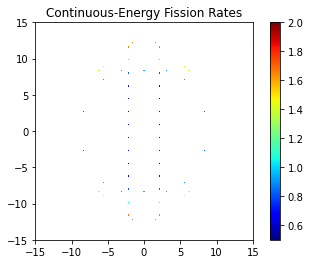

In [9]:
ce_fission_rates[ce_fission_rates == 0.] = np.nan
options = {
    'origin': 'lower',
    'extent': (xmin, xmax, ymin, ymax),
    'vmin': 0.50,
    'vmax': 2.00,
    'cmap': 'jet',
}
plt.imshow(img, **options)
plt.title('Continuous-Energy Fission Rates')
plt.colorbar()
plt.savefig('annular normal.png', format='png', dpi=1200)

In [10]:
ce_fission_rates

array([[[1.99600874]],

       [[1.65297627]],

       [[1.46965593]],

       [[1.42326017]],

       [[1.40743154]],

       [[1.44180786]],

       [[1.66811802]],

       [[2.00668719]],

       [[1.67837605]],

       [[1.0913094 ]],

       [[0.94699428]],

       [[0.91532239]],

       [[0.92120736]],

       [[1.07790894]],

       [[1.66367306]],

       [[1.48034802]],

       [[1.0750453 ]],

       [[0.95184694]],

       [[0.84271095]],

       [[0.75441227]],

       [[0.72851348]],

       [[0.81744696]],

       [[0.94639686]],

       [[1.06450578]],

       [[1.49069332]],

       [[1.40631522]],

       [[0.94783967]],

       [[0.82991807]],

       [[0.72287969]],

       [[0.66513743]],

       [[0.71560054]],

       [[0.83201327]],

       [[0.94881978]],

       [[1.40806081]],

       [[1.39787712]],

       [[0.90387877]],

       [[0.74398294]],

       [[0.70759375]],

       [[0.68273638]],

       [[0.63124841]],

       [[0.63515388]],

       [[0.68315